In [1]:
from torch import nn
import torch
import pandas as pd
import numpy as np
import os
from torchvision.io import read_image
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import transforms3d as tf

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transformer_model = nn.Transformer(batch_first=True)
BATCH_SIZE = 1
ENC_SEQ_LEN = 10
DEC_SEQ_LEN = 1
src = torch.rand((BATCH_SIZE, ENC_SEQ_LEN, transformer_model.d_model))
tgt = torch.rand((BATCH_SIZE, DEC_SEQ_LEN, transformer_model.d_model))
out = transformer_model(src, tgt)
out.flatten(start_dim=1).shape, out.shape

(torch.Size([1, 512]), torch.Size([1, 1, 512]))

In [3]:
encoder_layer = nn.TransformerEncoderLayer(d_model=6, nhead=3, batch_first=True)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
transformer_encoder

TransformerEncoder(
  (layers): ModuleList(
    (0): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
      )
      (linear1): Linear(in_features=6, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=6, bias=True)
      (norm1): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
      )
      (linear1): Linear(in_features=6, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=6, bias=True)


In [4]:
BATCH_SIZE = 1
ENC_SEQ_LEN = 15
src = torch.rand(BATCH_SIZE, ENC_SEQ_LEN, encoder_layer.self_attn.embed_dim)
out = transformer_encoder(src)
ENC_SEQ_LEN = 16
src = torch.rand(BATCH_SIZE, ENC_SEQ_LEN, encoder_layer.self_attn.embed_dim)
out = transformer_encoder(src)
out.shape, src

(torch.Size([1, 16, 6]),
 tensor([[[0.9021, 0.9657, 0.5434, 0.1544, 0.5695, 0.0367],
          [0.4557, 0.7599, 0.0987, 0.5648, 0.0280, 0.6468],
          [0.1517, 0.8067, 0.8794, 0.9307, 0.5737, 0.7026],
          [0.5835, 0.4599, 0.8370, 0.0679, 0.3210, 0.6412],
          [0.6422, 0.6267, 0.6186, 0.4398, 0.6975, 0.1942],
          [0.9078, 0.9344, 0.4046, 0.9408, 0.3008, 0.8868],
          [0.2291, 0.2943, 0.8430, 0.7871, 0.8424, 0.1610],
          [0.9522, 0.0118, 0.7903, 0.2436, 0.5367, 0.9406],
          [0.8604, 0.9560, 0.9314, 0.9394, 0.9064, 0.3704],
          [0.5353, 0.6977, 0.1310, 0.3204, 0.0220, 0.0531],
          [0.7249, 0.3266, 0.8181, 0.1048, 0.4685, 0.3665],
          [0.1539, 0.8670, 0.6206, 0.7160, 0.3192, 0.6916],
          [0.7642, 0.1992, 0.7992, 0.1437, 0.0778, 0.4400],
          [0.9634, 0.0096, 0.7245, 0.9139, 0.0732, 0.0664],
          [0.5997, 0.3766, 0.7865, 0.3219, 0.7487, 0.7957],
          [0.1110, 0.7721, 0.5351, 0.7114, 0.0792, 0.1917]]]))

In [5]:
data_dir = "indoor_forward_9_snapdragon_with_gt/"
imu_cols=["timestamp", "ang_vel_x", "ang_vel_y", "ang_vel_z", "lin_acc_x", "lin_acc_y", "lin_acc_z"]
imu_df = pd.read_csv(data_dir + "imu.txt", delimiter=' ', skiprows=1, names=imu_cols)
imu_df_nostamp = imu_df.loc[:, imu_df.columns != 'timestamp']
imu_df.index = pd.to_datetime(imu_df["timestamp"], unit='s')
imu_df

,timestamp,ang_vel_x,ang_vel_y,ang_vel_z,lin_acc_x,lin_acc_y,lin_acc_z
timestamp,,,,,,,
2018-10-29 14:20:16.292325120,1.540823e+09,-0.006392,-0.008522,-0.007457,0.052672,-0.158017,9.797023
2018-10-29 14:20:16.294326016,1.540823e+09,-0.005326,-0.006392,-0.006392,0.000000,-0.129286,9.768292
2018-10-29 14:20:16.296323072,1.540823e+09,-0.010653,-0.007457,-0.001065,-0.033519,-0.100556,9.749139
2018-10-29 14:20:16.298322944,1.540823e+09,-0.009587,-0.009587,-0.002131,0.043095,-0.110133,9.725197
2018-10-29 14:20:16.300322048,1.540823e+09,-0.005326,-0.005326,-0.004261,0.047884,-0.134075,9.782658
...,...,...,...,...,...,...,...
2018-10-29 14:21:33.118321920,1.540823e+09,-0.214118,-0.024501,0.415453,-5.956743,-0.397435,7.086801
2018-10-29 14:21:33.120321024,1.540823e+09,-0.238619,0.060720,0.476173,7.110743,1.402995,5.717324
2018-10-29 14:21:33.122322944,1.540823e+09,-0.295078,0.106526,0.288687,-3.969566,-0.181958,16.136837


In [6]:
imu_data = imu_df_nostamp.to_numpy(dtype=np.float32)
imu_data = torch.from_numpy(imu_data)
imu_data

tensor([[-6.3916e-03, -8.5221e-03, -7.4569e-03,  5.2672e-02, -1.5802e-01,
          9.7970e+00],
        [-5.3263e-03, -6.3916e-03, -6.3916e-03,  0.0000e+00, -1.2929e-01,
          9.7683e+00],
        [-1.0653e-02, -7.4569e-03, -1.0653e-03, -3.3519e-02, -1.0056e-01,
          9.7491e+00],
        ...,
        [-2.9508e-01,  1.0653e-01,  2.8869e-01, -3.9696e+00, -1.8196e-01,
          1.6137e+01],
        [-7.8830e-02, -7.3503e-02,  4.6019e-01, -1.6280e+00,  9.0979e-02,
          1.6472e+00],
        [-3.4834e-01,  3.0893e-02,  3.9202e-01,  6.1435e+00,  2.1596e+00,
          9.7204e+00]])

In [7]:
src = imu_data[:ENC_SEQ_LEN].unsqueeze(0)
transformer_encoder(src)

tensor([[[-0.1215, -1.6311,  0.7279,  1.2233,  0.7004, -0.8989],
         [-0.2417, -1.4299,  0.8322,  1.1941,  0.7488, -1.1036],
         [-0.2309, -1.5588,  0.6988,  1.2819,  0.7312, -0.9223],
         [-0.0930, -1.4704,  0.5450,  1.3511,  0.7423, -1.0750],
         [-0.2005, -1.6990,  0.7201,  1.3913,  0.4401, -0.6520],
         [-0.2701, -1.5399,  0.7880,  1.1052,  0.8830, -0.9662],
         [-0.3788, -1.5728,  0.7072,  1.2502,  0.8093, -0.8152],
         [ 0.0607, -1.6410,  0.8697,  1.1378,  0.5484, -0.9756],
         [-0.2978, -1.6113,  0.7671,  1.3367,  0.5812, -0.7759],
         [-0.2473, -1.6241,  0.9086,  1.1534,  0.6554, -0.8459],
         [-0.5055, -1.4536,  0.4979,  1.3880,  0.8894, -0.8161],
         [-0.3713, -1.5213,  0.7337,  1.0554,  1.0239, -0.9204],
         [-0.2472, -1.4982,  0.8287,  1.1911,  0.7434, -1.0179],
         [-0.1642, -1.4938,  0.5572,  1.1151,  1.0387, -1.0530],
         [-0.2339, -1.5075,  0.7342,  1.2542,  0.7511, -0.9982],
         [-0.3220, -1.694

In [8]:
class IMUDataset(Dataset):
    def __init__(self, data_dir, label_file, seq_len):
        imu_cols=["timestamp", "ang_vel_x", "ang_vel_y", "ang_vel_z", "lin_acc_x", "lin_acc_y", "lin_acc_z"]
        self.imu_df = pd.read_csv(data_dir + "imu.txt", delimiter=' ', skiprows=1, names=imu_cols)
        self.imu_df.index = pd.to_datetime(self.imu_df["timestamp"], unit='s')
        imu_df_nostamp = self.imu_df.loc[:, self.imu_df.columns != 'timestamp']
        self.imu_data = imu_df_nostamp.to_numpy(dtype=np.float32)
        self.imu_data = torch.from_numpy(self.imu_data)

        label_cols=["timestamp","tx","ty","tz","qx","qy","qz","qw","none"]
        self.labels_df = pd.read_csv(label_file, delimiter=' ', skiprows=1, names=label_cols)
        self.labels_df = self.labels_df.iloc[: , :-1]
        self.labels_df["timestamp"] = pd.to_datetime(self.labels_df["timestamp"], unit='s')
        labels_df_nostamp = self.labels_df.loc[:, self.labels_df.columns != 'timestamp']
        self.labels = torch.tensor(labels_df_nostamp.to_numpy(), dtype=torch.float32)

        self.seq_len = seq_len
        self.delta = seq_len

    def __len__(self):
        return self.labels.shape[0] - self.delta

    def __getitem__(self, idx):
        # TODO: could optimize for better performance (pretty quick anyway)
        label_ts = self.labels_df.iloc[idx]["timestamp"]
        label_ts_end = self.labels_df.iloc[idx+self.delta]["timestamp"]

        dpose = torch.zeros(7)
        l1 = self.labels[idx]
        l2 = self.labels[idx+self.delta]
        dl = l2-l1 # position delta
        dpose[:3] = dl[:3]
        q1 = l1[3:][[3,0,1,2]] # rearange quaternion, w goes first
        q2 = l2[3:][[3,0,1,2]] # rearange quaternion, w goes first
        dq = tf.quaternions.qmult(q2, tf.quaternions.qinverse(q1)) # orientation delta
        dpose[3:] = torch.tensor(dq, dtype=torch.float32) # pose delta is the label

        imu_index_start = self.imu_df.index.get_loc(label_ts, method='nearest')
        imu_index_end = self.imu_df.index.get_loc(label_ts_end, method='nearest')
        imu = self.imu_data[imu_index_start:imu_index_end]

        return imu, dpose

ENC_SEQ_LEN = 128
vio_dataset = IMUDataset(data_dir, data_dir + "groundtruth.txt", ENC_SEQ_LEN)
vio_dataset.__getitem__(500)

(tensor([[-2.8443e-01, -9.9070e-02, -1.5766e-01,  3.7110e+00, -2.7294e-01,
           1.4705e+01],
         [ 3.4088e-02, -1.5766e-01, -5.3263e-02, -6.9958e+00, -5.6982e-01,
           9.7108e+00],
         [ 3.1532e-01,  1.3955e-01,  1.8323e-01,  1.0343e+00,  7.4220e-01,
           4.2617e-01],
         [-1.1079e-01,  7.6699e-02, -7.6699e-02,  3.5817e+00, -2.0015e+00,
           1.4365e+01],
         [-3.8350e-02, -1.0333e-01, -1.7790e-01, -7.8482e+00, -4.6926e-01,
           1.4581e+01],
         [ 8.2025e-02,  1.6725e-01, -1.0653e-02,  5.8083e+00,  6.7037e-01,
           1.0903e+01],
         [ 8.2025e-02,  1.6725e-01, -1.0653e-02,  5.8083e+00,  6.7037e-01,
           1.0903e+01],
         [-7.2438e-02, -3.4515e-01,  1.5766e-01, -1.3886e+00,  4.7884e-03,
           4.3957e+00],
         [-1.3742e-01, -8.5221e-03,  1.3103e-01,  7.1395e+00,  4.2617e-01,
           9.9359e+00],
         [-3.1958e-02,  3.6219e-02, -6.4981e-02, -2.3511e+00, -2.3415e+00,
           1.5586e+01],
         [

In [9]:
import time
s = time.time()
for i in range(1000):
    vio_dataset.__getitem__(i)
dt = time.time() - s
dt / 1000, dt # fast enough :?)

(0.001957772493362427, 1.9577724933624268)

In [10]:
data_point = vio_dataset.__getitem__(0)[0].unsqueeze(0)
transformer_encoder(data_point).shape

torch.Size([1, 128, 6])

In [11]:
class IMUTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=6, nhead=6, dim_feedforward=32, batch_first=True)
        transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.encoder = transformer_encoder
        self.fc1 = nn.Linear(in_features=6, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=7)

    def forward(self, x):
        x = torch.relu(self.encoder(x))
        x = torch.relu(self.fc1(x[:,-1,:]))
        x = self.fc2(x)
        return x

model = IMUTransformer()
model(data_point)

tensor([[ 0.2236,  0.1485, -0.5674, -0.1074, -0.1576,  0.3004,  0.0220]],
       grad_fn=<AddmmBackward0>)

In [12]:
model = model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005) # .01 works for initial ~20 epochs
dataloader = torch.utils.data.DataLoader(vio_dataset, batch_size=64*2, shuffle=True, num_workers=4)
next(iter(dataloader))[0].shape

torch.Size([128, 128, 6])

In [19]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html training loop from here

torch.cuda.empty_cache()

num_epochs = 10
for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0

        # Iterate over data.
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(vio_dataset)

        print(f'{phase} Loss: {epoch_loss:.4f}')

Epoch 0/9
----------
train Loss: 0.0515
Epoch 1/9
----------
train Loss: 0.0524
Epoch 2/9
----------
train Loss: 0.0472
Epoch 3/9
----------
train Loss: 0.0485
Epoch 4/9
----------
train Loss: 0.0454
Epoch 5/9
----------
train Loss: 0.0509
Epoch 6/9
----------
train Loss: 0.0442
Epoch 7/9
----------
train Loss: 0.0396
Epoch 8/9
----------
train Loss: 0.0419
Epoch 9/9
----------
train Loss: 0.0377


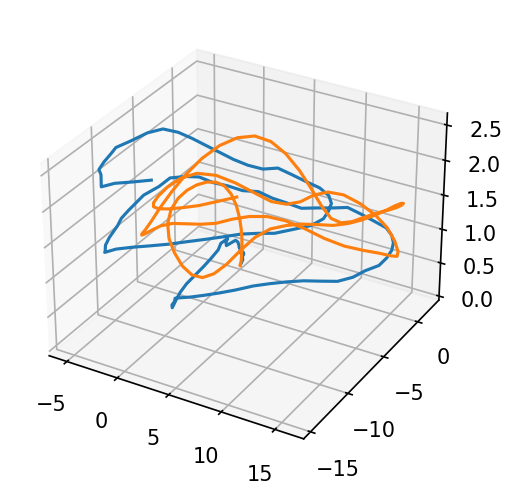

In [28]:
model.eval()
path = []
ground = []
x = np.zeros((3,1))
gtx = np.zeros((3,1))
for i in range(int(len(vio_dataset)/ENC_SEQ_LEN)):
    data_point = vio_dataset.__getitem__(i*ENC_SEQ_LEN)
    delta_label = data_point[1].numpy().reshape(7,1)[:3]
    gtx += delta_label
    ground.append(gtx.copy())
    inputs = data_point[0].unsqueeze(0).to(device)
    outputs = model(inputs)
    dx = outputs.cpu().detach().numpy().T[:3]
    x += dx
    path.append(x.copy())
path = np.array(path).reshape(-1,3)
ground = np.array(ground).reshape(-1,3)
fig = plt.figure(dpi=150)
ax = plt.axes(projection='3d')
ax.plot3D(path[:,0],path[:,1],path[:,2])
ax.plot3D(ground[:,0],ground[:,1],ground[:,2])
# 11,24

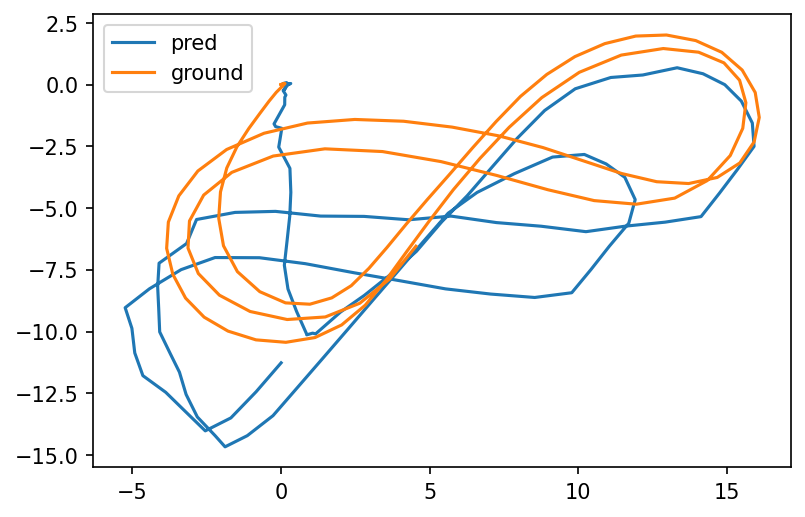

In [29]:
plt.figure(dpi=150)
plt.plot(path[:,0],path[:,1])
plt.plot(ground[:,0],ground[:,1])
plt.legend(["pred","ground"])

In [31]:
np.linalg.norm(path[-1] - ground[-1]) # how far away from the actual, at the end of trajectory ?

6.562042616438624

In [66]:
df = vio_dataset.imu_df
integrated_path = []
integ = np.zeros((3,1))
euler = np.zeros((3,1))
R = np.eye(3)
for index in range(len(df)-1):
    curr = df.iloc[index+1]
    prev = df.iloc[index]
    dt = (curr["timestamp"] - prev["timestamp"])
    acceleration = np.array([
        prev["lin_acc_x"],
        prev["lin_acc_y"],
        prev["lin_acc_z"]
    ]).reshape((3,1))
    euler = (np.array([
        prev["ang_vel_x"], 
        prev["ang_vel_y"],
        prev["ang_vel_z"]
    ])*dt).reshape(3,1)
    integ += R @ (1/2*acceleration*dt**2)
    integrated_path.append(integ.copy())
    R = tf.euler.euler2mat(euler[0],euler[1],euler[2]) @ R
integrated_path = np.array(integrated_path).reshape(-1,3)
integrated_path.shape

(38417, 3)

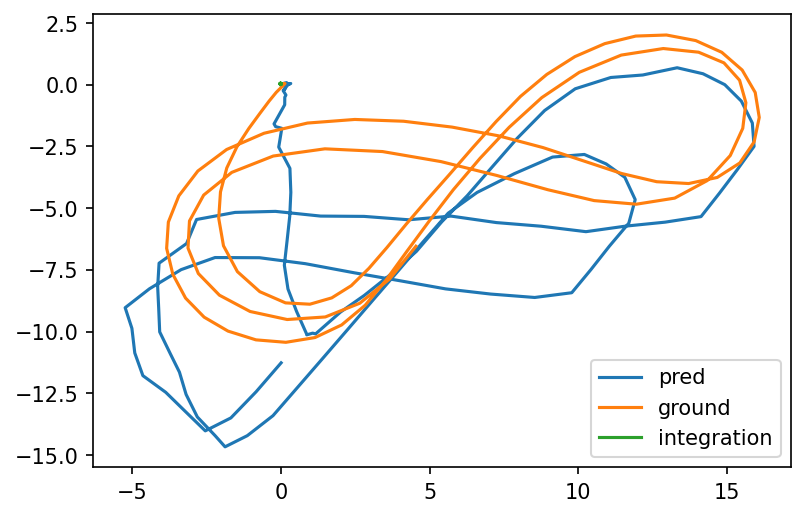

In [68]:
plt.figure(dpi=150)
plt.plot(path[:,0],path[:,1])
plt.plot(ground[:,0],ground[:,1])
plt.plot(integrated_path[:,0],integrated_path[:,1])
plt.legend(["pred","ground","integration"])